In [7]:
f = open('/Users/rebecca/Documents/PhD/Research/Frequency/Olsen and Allen/mag-dist.csv')

    
a = f.read()
b = a.split('\n')
c = []
for i in b:
    if i!='':
        c.append(i.split(','))

In [23]:
body = []
local = []
revised_local = []
md = []
moment = []
other = []
for i in c:
    m = float(i[0])
    mt = i[1]
    if mt=='mb' or mt=='mb_lg':
        body.append(m)
    elif mt=='ml':
        local.append(m)
    elif mt=='mlr':
        revised_local.append(m)    
    elif mt=='md':
        md.append(m)    
    elif mt=='mww' or mt=='mwr' or mt=='mw' or mt=='mwb':
        moment.append(m) 
    else:
        other.append(m)

In [39]:
%%capture
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,3, figsize=(12.8,9.6))

In [40]:
import numpy as np
b = list(np.arange(3, 8, 0.1))
axs[0][0].hist(body, bins=b)
axs[0][0].set_title('body')
axs[0][1].hist(local, bins=b)
axs[0][1].set_title('local')
axs[0][2].hist(revised_local, bins=b)
axs[0][2].set_title('revised local')
axs[1][0].hist(md, bins=b)
axs[1][0].set_title('md')
axs[1][1].hist(moment, bins=b)
axs[1][1].set_title('moment')
axs[1][2].hist(other, bins=b)
axs[1][2].set_title('other')

Text(0.5, 1.0, 'other')

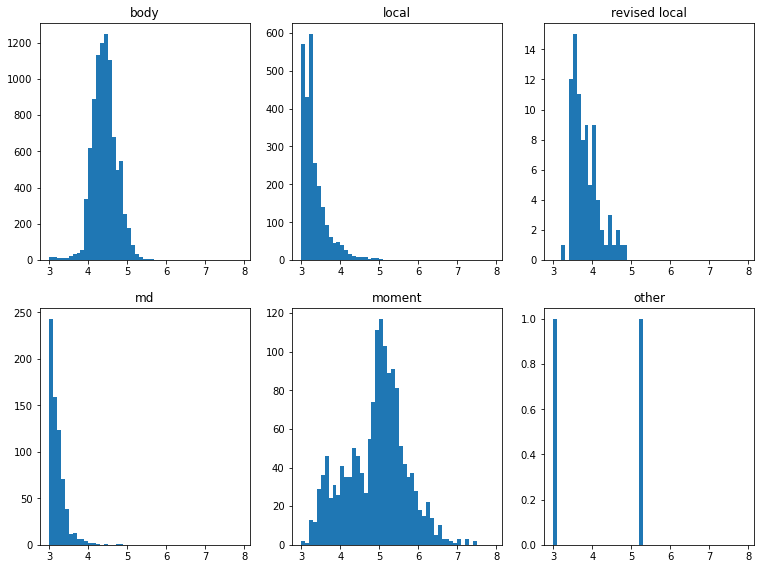

In [41]:
fig

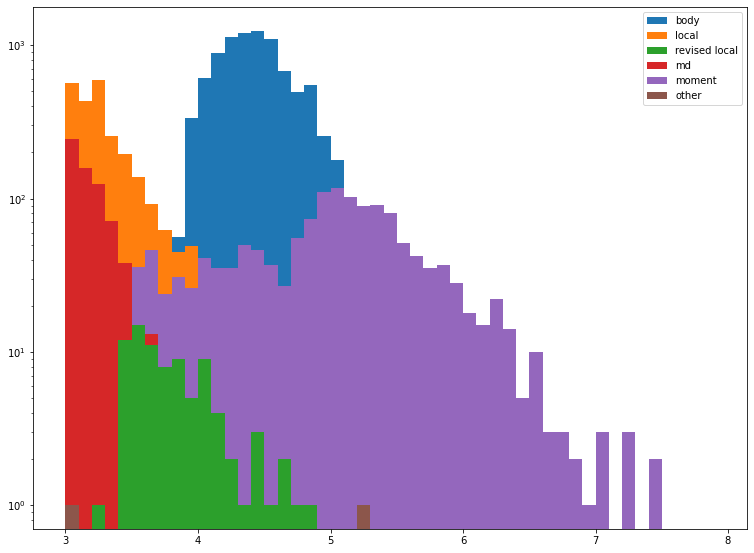

In [57]:
import numpy as np
b = list(np.arange(3, 8, 0.1))
fig, axs = plt.subplots(1,1, figsize = (12.8,9.6))
axs.hist(body, bins=b, label='body')
axs.hist(local, bins=b, label='local', zorder = 2)
axs.hist(revised_local, bins=b, label='revised local', zorder = 5)
axs.hist(md, bins=b, label='md', zorder = 4)
axs.hist(moment, bins=b, label='moment', zorder = 3)
axs.hist(other, bins=b, label='other', zorder = 6)
axs.set_yscale('log')
plt.legend()